In [76]:
# Xception- Visual explanations - Gradcam  Gradcam++   Hyperparameters tuning with traning Batch normalization -Accuracy 89%

##  Xception - Visual-explanations- Gradcam | Gradcam++   

### Import libraries.

In [2]:
import os

import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import Xception ,preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(123)

### Loading Datasets

In [3]:
path = os.path.join('D:\\FYP\Datasets\\', 'TotalNvAndMelNoDuplicatesFullSize_244.zip')
path

'D:\\FYP\\Datasets\\TotalNvAndMelNoDuplicatesFullSize_244.zip'

In [5]:
X_df = pd.read_pickle(path)
print("X_df.shape =", X_df.shape)
print("Inspect X_df", os.linesep, X_df.head())

X_df.shape = (6017, 3)
Inspect X_df 
        image_id                                              image  id
0  ISIC_0024698  [[[162, 137, 166], [163, 137, 164], [164, 138,...   1
1  ISIC_0024693  [[[229, 151, 167], [230, 147, 163], [230, 146,...   1
2  ISIC_0025964  [[[128, 103, 109], [130, 110, 112], [137, 108,...   0
3  ISIC_0027190  [[[131, 109, 130], [131, 110, 129], [135, 114,...   0
4  ISIC_0031023  [[[20, 8, 18], [18, 5, 14], [13, 4, 9], [18, 5...   0


In [6]:
X_df.to_csv('TotalNvAndMelNoDuplicatesFullSize_244.csv')

In [7]:
df_scv = pd.read_csv('TotalNvAndMelNoDuplicatesFullSize_244.csv')
df_scv["image"] =X_df['image']

MEL 0: 614
NV  1: 5403
Proportion: 0.11 : 1


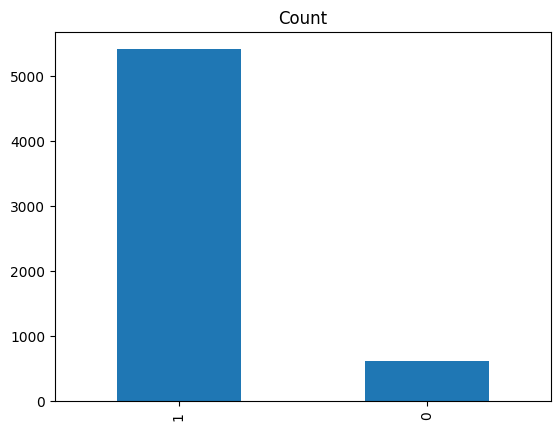

In [8]:
count = df_scv.id.value_counts()
print('MEL 0:', count[0])
print('NV  1:', count[1])
print('Proportion:', round(count[0] / count[1], 2), ': 1')

count.plot(kind='bar', title='Count');

In [9]:
num_images=df_scv['image'].shape
num_images

(6017,)

In [10]:
# Class count
count_class_1, count_class_0 = df_scv.id.value_counts()

# Divide by class
df_class_0 = df_scv[df_scv['id'] == 0]
df_class_1 = df_scv[df_scv['id'] == 1]

In [11]:
df_class_0=df_class_0.drop(columns="Unnamed: 0")

In [12]:
df_class_1=df_class_1.drop(columns="Unnamed: 0")

### Random Under-sampling

Random over-sampling:
1    614
0    614
Name: id, dtype: int64


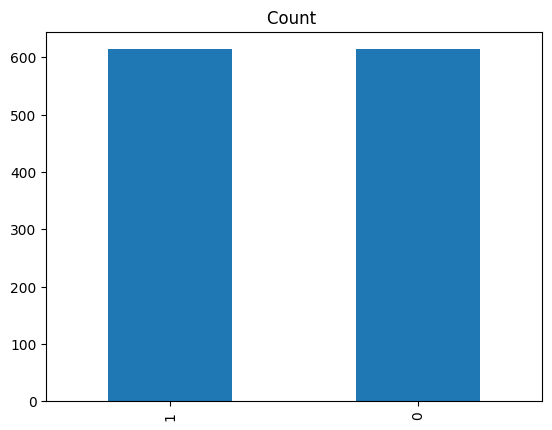

In [13]:
# Random over-sampling
df_class_0_over = df_class_0
df_class_1_under = df_class_1.sample(614, replace=True)

df_over_sampling = pd.concat([df_class_1_under, df_class_0_over],  ignore_index=True,axis=0)

print('Random over-sampling:')
print(df_over_sampling.id.value_counts())

df_over_sampling.id.value_counts().plot(kind='bar', title='Count ');

In [14]:
df_over_sampling

image_id                                              image  id
0     ISIC_0029411  [[[201, 107, 141], [200, 120, 147], [202, 115,...   1
1     ISIC_0029670  [[[188, 97, 106], [168, 83, 90], [180, 103, 11...   1
2     ISIC_0027962  [[[190, 87, 108], [190, 91, 111], [198, 97, 11...   1
3     ISIC_0032585  [[[179, 136, 179], [181, 145, 183], [183, 149,...   1
4     ISIC_0033589  [[[3, 2, 0], [3, 3, 3], [3, 1, 6], [3, 2, 0], ...   1
...            ...                                                ...  ..
1223  ISIC_0028493  [[[185, 155, 155], [184, 154, 154], [192, 158,...   0
1224  ISIC_0028968  [[[217, 184, 179], [210, 172, 171], [210, 172,...   0
1225  ISIC_0032389  [[[117, 80, 88], [118, 82, 92], [120, 82, 93],...   0
1226  ISIC_0025500  [[[163, 138, 133], [161, 131, 129], [165, 134,...   0
1227  ISIC_0032985  [[[244, 231, 241], [246, 237, 254], [250, 233,...   0

[1228 rows x 3 columns]

In [15]:
# Store number of images in the dataset
num_images = df_over_sampling.shape[0]
num_classes = 2
print(num_images)

1228


In [16]:
# Get y, a vector containing the classes for each image
y = df_over_sampling.pop('id')

In [17]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1223    0
1224    0
1225    0
1226    0
1227    0
Name: id, Length: 1228, dtype: int64

In [18]:
# Allocate space for all images
X = np.empty((num_images, 224, 224, 3),dtype='uint8')

In [19]:
for i in range(0, num_images):
      
    X[i, :, :, :] = np.reshape(df_over_sampling['image'][i], (224, 224, 3)) 

print(y[:].value_counts())

print("X.shape =", X.shape)
print("y.shape =", y.shape)

1    614
0    614
Name: id, dtype: int64
X.shape = (1228, 224, 224, 3)
y.shape = (1228,)


In [20]:
df_over_sampling['image'][0].shape

(224, 224, 3)

In [21]:
X.shape, y.shape

((1228, 224, 224, 3), (1228,))

### Visualize some images / labels for each classes.

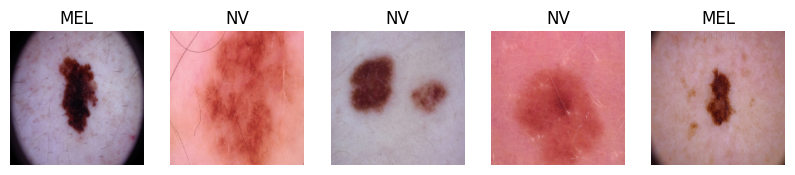

In [22]:
# visualize some images / labels
class_names = ['MEL', 'NV']

W_grid=5
L_grid=1
fig,axes = plt.subplots(L_grid,W_grid,figsize=(10,10))
axes=axes.ravel()
n_training=len(X)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) #Pick a random number 
    axes[i].imshow(X[index])
#     print(y_train[index].tolist())
    axes[i].set_title(class_names[y[index]]) #Prints labels on top of the picture
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

### Split datasets to train and test.

In [23]:
## split train / test

# indices_train, indices_test = train_test_split(list(range(X.shape[0])), train_size=0.8, test_size=0.2, random_state=28)

# x_train = X[indices_train]
# y_train = y[indices_train]
# x_test = X[indices_test]
# y_test = y[indices_test]

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.25,random_state=28)


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)


(736, 224, 224, 3) (736,)
(246, 224, 224, 3) (246,)
(246, 224, 224, 3) (246,)


### Label Encoding & Augmentation.

In [24]:
n_classes=2
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
y_val = keras.utils.to_categorical(y_val , n_classes)

y_train.shape, y_test.shape, y_val.shape

((736, 2), (246, 2), (246, 2))

In [23]:
# list(y_test)

In [24]:
## to image data generator

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)

datagen_val = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

## Hyperparameter Tuning (Bayesian optimization using Gaussian Processes.)

In [45]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import keras.backend as K

space = [Real(1e-6, 0.01, "log-uniform", name='learning_rate'),
          Real(0.1, 0.8, name='dropout'),
          Real(0.8, 1.0, name='momentum'),
          Real(0.9, 1.0, name='beta_1'),
          Real(0.99, 1.0, name='beta_2'),
          Integer(low=1,high=100, name = 'epochs'),
          Integer(low=50, high=225, name='num_dense_nodes'),
          Categorical(categories=['SGD', 'Adam'],
                             name='optimizer_type')
          ]

In [46]:
from keras.optimizers import Adam, SGD

W=224
H=224

def make_model(learning_rate, dropout, momentum, beta_1, beta_2,
               num_dense_nodes, optimizer_type):
    """build model function"""
    print("Start MK")
    # Xception
    input_tensor = Input(shape=(W, H, 3)) # To change input shape
    xception = Xception(
        include_top=False,                # To change output shape
        weights='imagenet',               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
    
    # frozen weights
    for layer in xception.layers[:-10]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable

    # Add extra dense layers
    x = xception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_dense_nodes, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(rate=dropout)(x)
    predictions = Dense(n_classes, activation='sigmoid')(x)
    model = Model(inputs=xception.input, outputs=predictions)
    
    if optimizer_type == "Adam":
        optimizer = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif optimizer_type == "SGD":
        optimizer = SGD(lr=learning_rate, momentum=momentum)

    model.compile(loss='binary_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])
    return model

In [48]:
n_trials = 2

batch_size = 32
best_accuracy = {} 
for seed in range(n_trials):
    best_accuracy[seed] = 0.0

for seed in range(n_trials):
    print('We are currently training on seed:', seed)
    # for each iteration of the hyperparameter search, return a set of parameters
    # and feed them into the relevant parts
    # run training of the model for this seed, save with seed num
    ##---------> #  X_train, y_train, X_test, y_test = data_splits[seed]
    path_best_model = 'Xception_saved_trial_{}.h5'.format(seed)
    
    @use_named_args(dimensions=space)
    def fitness(learning_rate, dropout, momentum, beta_1, beta_2,
               num_dense_nodes, optimizer_type, epochs):
        # Print the hyper-parameters.
        print('learning rate: {0:.1e}'.format(learning_rate))
        print('num_dense_nodes:', num_dense_nodes)
        print('dropout:', dropout)
        print('optimizer_type:', optimizer_type)
        print('epochs:', epochs)
        
        # Create the neural network with these hyper-parameters.
        model = make_model(learning_rate=learning_rate, 
                         dropout=dropout, 
                         momentum=momentum, 
                         beta_1=beta_1, beta_2=beta_2,
                         num_dense_nodes=num_dense_nodes, 
                         optimizer_type=optimizer_type)
        # Use Keras to train the model.
#         history = model.fit(x=x_train,
#                           y=y_train,
#                           epochs=epochs,
#                           batch_size=batch_size,
#                           validation_data= (x_val,y_val))
        
        history=model.fit_generator(
        datagen_train.flow(x_train, y_train, batch_size=32),
        epochs=epochs,
        steps_per_epoch = int( np.ceil(x_train.shape[0] / batch_size) ),  
        validation_data=datagen_val.flow(x_val, y_val, batch_size=32))
    

        # Get the classification accuracy on the validation-set
        # after the last training-epoch.
        accuracy = history.history['val_accuracy'][-1]
        
        # Print the classification accuracy.
        print()
        print("Accuracy: {0:.2%}".format(accuracy))
        print()
        
        # Save the model if it improves on the best-found performance.
        # We use the global keyword so we update the variable outside
        # of this function.
        global best_accuracy
        global best_history_1
        global best_history_2
        
        
        if accuracy > best_accuracy[seed]:
            # Save the new model to harddisk, again change /PathToOutputDirectory to your path
            model_path = os.path.join('D:\\FYP\\Models\\', path_best_model)
            model.save(model_path)
            
            if(seed==0):
                best_history_1=history
            else:
                best_history_2=history                
                
            
            np.save('Xception_saved_trial_history_{}.npy'.format(seed),history.history)
            
            # Update the classification accuracy.
            best_accuracy[seed] = accuracy
            
        # Delete the Keras model with these hyper-parameters from memory.
        del model
        
        K.clear_session()
        
        return -accuracy
    
    
    #This conducts the hyperparameter search over each data split for details see: https://scikit-optimize.github.io/#skopt.gp_minimize
    search_result = gp_minimize(func=fitness,
                                dimensions=space,
                                acq_func='EI', # Expected Improvement.
                                n_calls=3,
                                n_random_starts = 3,
                                verbose = True)
    print('Seed: ',seed)
    print("BEST ACCURACY: ", best_accuracy)
    print('hyper_params ', search_result.x)

We are currently training on seed: 0
Iteration No: 1 started. Evaluating function at random point.
learning rate: 1.3e-04
num_dense_nodes: 171
dropout: 0.5533474631050721
optimizer_type: Adam
epochs: 86
Start MK
Epoch 1/86
23/23 [==============================] - 271s 12s/step - loss: 0.6024 - accuracy: 0.7255 - val_loss: 0.6535 - val_accuracy: 0.5528
Epoch 2/86
23/23 [==============================] - 257s 11s/step - loss: 0.4311 - accuracy: 0.8139 - val_loss: 0.6335 - val_accuracy: 0.6138
Epoch 3/86
23/23 [==============================] - 257s 11s/step - loss: 0.3636 - accuracy: 0.8370 - val_loss: 0.6120 - val_accuracy: 0.6463
Epoch 4/86
23/23 [==============================] - 257s 11s/step - loss: 0.3241 - accuracy: 0.8533 - val_loss: 0.5334 - val_accuracy: 0.7317
Epoch 5/86
23/23 [==============================] - 257s 11s/step - loss: 0.2962 - accuracy: 0.8668 - val_loss: 0.6783 - val_accuracy: 0.6789
Epoch 6/86
23/23 [==============================] - 260s 11s/step - loss: 0.28

Epoch 57/86
23/23 [==============================] - 257s 11s/step - loss: 0.0094 - accuracy: 0.9959 - val_loss: 0.6873 - val_accuracy: 0.8740
Epoch 58/86
23/23 [==============================] - 257s 11s/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.7054 - val_accuracy: 0.8577
Epoch 59/86
23/23 [==============================] - 258s 11s/step - loss: 0.0124 - accuracy: 0.9946 - val_loss: 1.1211 - val_accuracy: 0.8577
Epoch 60/86
23/23 [==============================] - 257s 11s/step - loss: 0.0130 - accuracy: 0.9946 - val_loss: 0.9727 - val_accuracy: 0.8374
Epoch 61/86
23/23 [==============================] - 257s 11s/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.9754 - val_accuracy: 0.8049
Epoch 62/86
23/23 [==============================] - 257s 11s/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.8325 - val_accuracy: 0.8211
Epoch 63/86
23/23 [==============================] - 257s 11s/step - loss: 0.0159 - accuracy: 0.9932 - val_loss: 0.7326 - val_accuracy: 0.8699

23/23 [==============================] - 257s 11s/step - loss: 0.6812 - accuracy: 0.6101 - val_loss: 0.6746 - val_accuracy: 0.6463
Epoch 27/56
23/23 [==============================] - 256s 11s/step - loss: 0.6762 - accuracy: 0.6196 - val_loss: 0.6737 - val_accuracy: 0.6504
Epoch 28/56
23/23 [==============================] - 256s 11s/step - loss: 0.6781 - accuracy: 0.6168 - val_loss: 0.6729 - val_accuracy: 0.6748
Epoch 29/56
23/23 [==============================] - 257s 11s/step - loss: 0.6778 - accuracy: 0.6196 - val_loss: 0.6722 - val_accuracy: 0.6748
Epoch 30/56
23/23 [==============================] - 257s 11s/step - loss: 0.6755 - accuracy: 0.6155 - val_loss: 0.6716 - val_accuracy: 0.6789
Epoch 31/56
23/23 [==============================] - 257s 11s/step - loss: 0.6766 - accuracy: 0.6318 - val_loss: 0.6710 - val_accuracy: 0.6748
Epoch 32/56
23/23 [==============================] - 275s 12s/step - loss: 0.6768 - accuracy: 0.6359 - val_loss: 0.6704 - val_accuracy: 0.6748
Epoch 33/56

23/23 [==============================] - 330s 14s/step - loss: 0.7133 - accuracy: 0.4973 - val_loss: 0.7239 - val_accuracy: 0.4309
Epoch 83/99
23/23 [==============================] - 333s 14s/step - loss: 0.7142 - accuracy: 0.4973 - val_loss: 0.7240 - val_accuracy: 0.4268
Epoch 84/99
23/23 [==============================] - 304s 13s/step - loss: 0.7132 - accuracy: 0.4715 - val_loss: 0.7239 - val_accuracy: 0.4309
Epoch 85/99
23/23 [==============================] - 6219s 11s/step - loss: 0.7138 - accuracy: 0.4878 - val_loss: 0.7236 - val_accuracy: 0.4309
Epoch 86/99
23/23 [==============================] - 259s 11s/step - loss: 0.7099 - accuracy: 0.4973 - val_loss: 0.7236 - val_accuracy: 0.4309
Epoch 87/99
23/23 [==============================] - 258s 11s/step - loss: 0.7134 - accuracy: 0.4810 - val_loss: 0.7231 - val_accuracy: 0.4268
Epoch 88/99
23/23 [==============================] - 258s 11s/step - loss: 0.7099 - accuracy: 0.4769 - val_loss: 0.7228 - val_accuracy: 0.4350
Epoch 89/9

23/23 [==============================] - 258s 11s/step - loss: 0.2529 - accuracy: 0.8845 - val_loss: 1.4016 - val_accuracy: 0.8577
Epoch 6/37
23/23 [==============================] - 258s 11s/step - loss: 0.2439 - accuracy: 0.9049 - val_loss: 0.5022 - val_accuracy: 0.8537
Epoch 7/37
23/23 [==============================] - 258s 11s/step - loss: 0.2332 - accuracy: 0.8913 - val_loss: 0.7063 - val_accuracy: 0.8740
Epoch 8/37
23/23 [==============================] - 258s 11s/step - loss: 0.1873 - accuracy: 0.9130 - val_loss: 0.8506 - val_accuracy: 0.8130
Epoch 9/37
23/23 [==============================] - 258s 11s/step - loss: 0.1697 - accuracy: 0.9280 - val_loss: 0.6892 - val_accuracy: 0.8455
Epoch 10/37
23/23 [==============================] - 258s 11s/step - loss: 0.1258 - accuracy: 0.9429 - val_loss: 1.1378 - val_accuracy: 0.8740
Epoch 11/37
23/23 [==============================] - 258s 11s/step - loss: 0.1187 - accuracy: 0.9538 - val_loss: 0.8923 - val_accuracy: 0.8699
Epoch 12/37
23/

In [49]:
best_accuracy

{0: 0.8658536672592163, 1: 0.8739837408065796}

In [50]:
best_history_1

In [51]:
best_history_2

 ### Analysis training and validation results

In [25]:
label_to_class = {
    'Mel': 0,
    'Nv' : 1}

In [26]:
class_to_label = {v: k for k, v in label_to_class.items()}

### Load saved  best model

In [45]:
import tensorflow as tf
model= tf.keras.models.load_model('D:\\FYP\\Models\\Xception_saved_trial_1.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

 #### confusion matrix

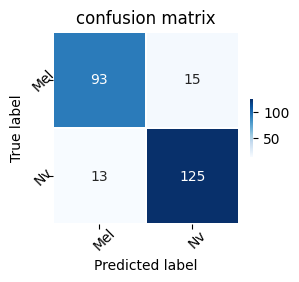

In [74]:
## plot confusion matrix

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1) 
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(3, 2.5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [75]:
cm

array([[ 93,  15],
       [ 13, 125]], dtype=int64)

#### classification report

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf

In [31]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_trues, y_preds) * 100))

Accuracy: 88.62%


In [32]:
print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       108
           1       0.89      0.91      0.90       138

    accuracy                           0.89       246
   macro avg       0.89      0.88      0.88       246
weighted avg       0.89      0.89      0.89       246



In [33]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

total=sum(sum(cm))
#####from confusion matrix calculate accuracy
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)


Accuracy :  0.8861788617886179
Sensitivity :  0.8611111111111112
Specificity :  0.9057971014492754


### Graphing our training and validation

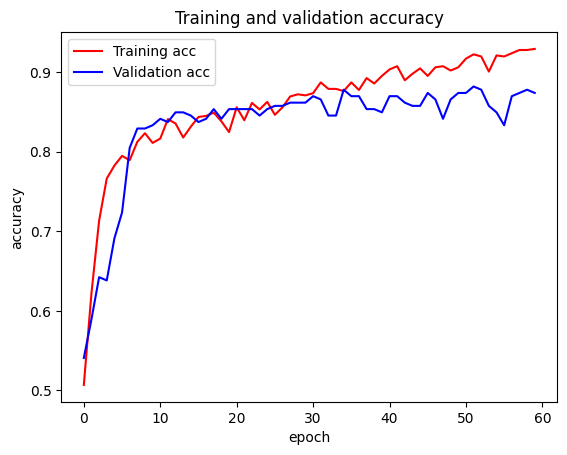

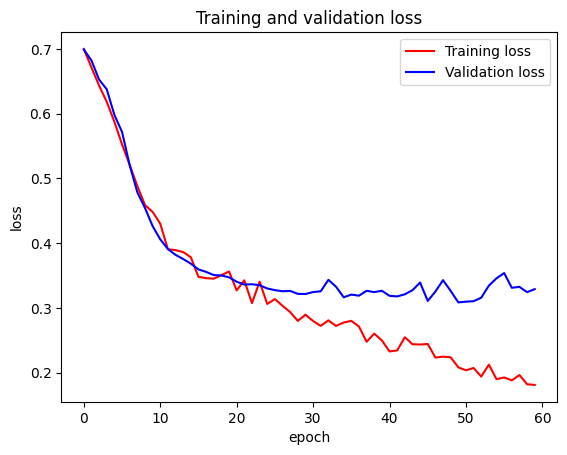

In [791]:
history=best_history_2
history.history.keys()

#Graphing our training and validation
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

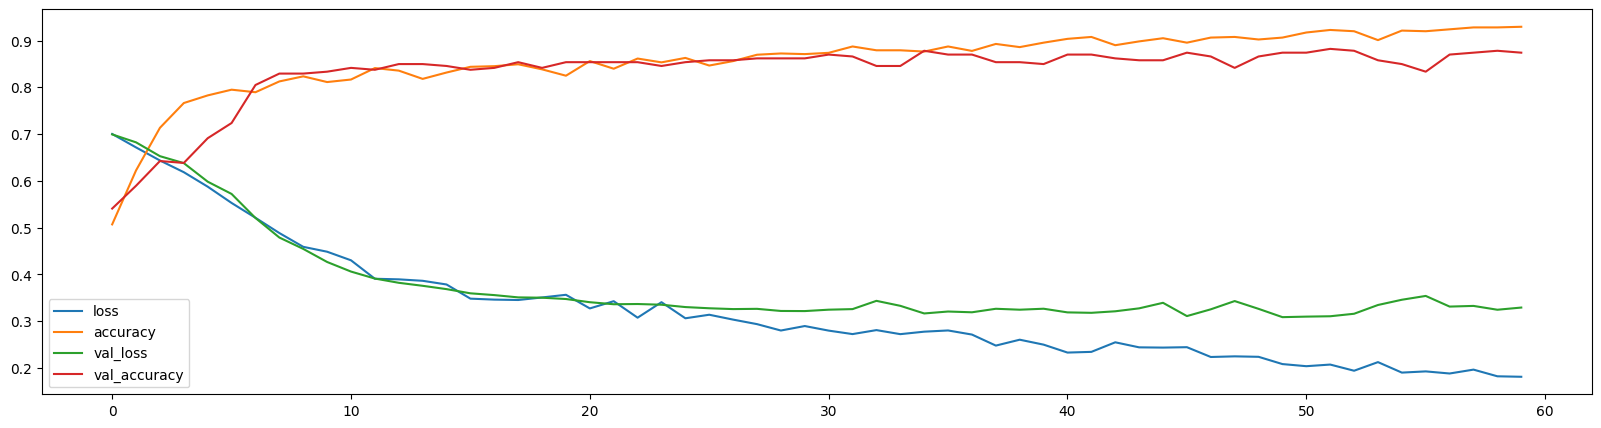

In [792]:
pd.DataFrame(history.history).plot(figsize=(20,5))
plt.show()

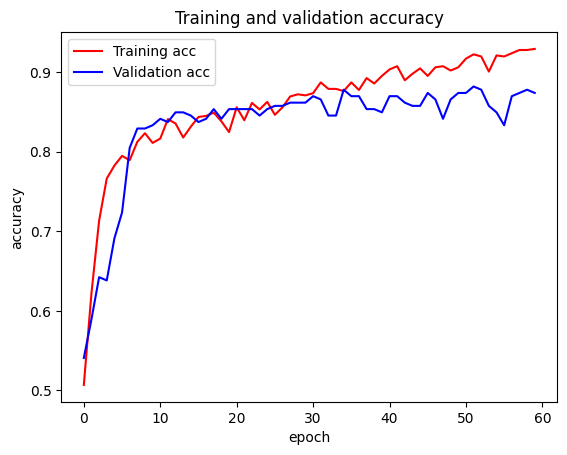

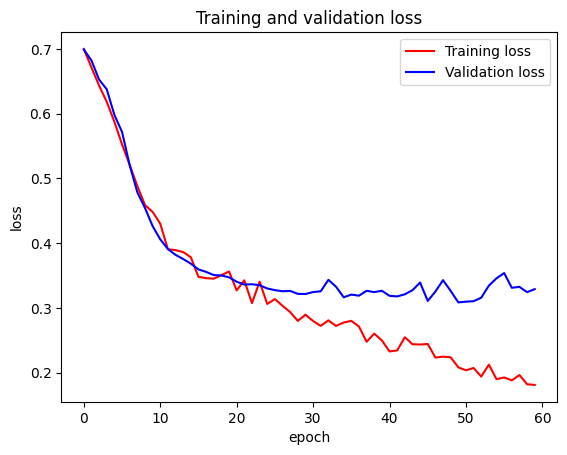

In [72]:
history=np.load('D:\\FYP\\Xception_saved_trial_history_1.npy',allow_pickle='TRUE').item()
history.keys()

#Graphing our training and validation
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

##### ROC and AUC

In [73]:
from tqdm import tqdm
import gc
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(datagen_test.flow(x_test, batch_size=32, shuffle=False),steps = len(x_test)/32)    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.27s/it]


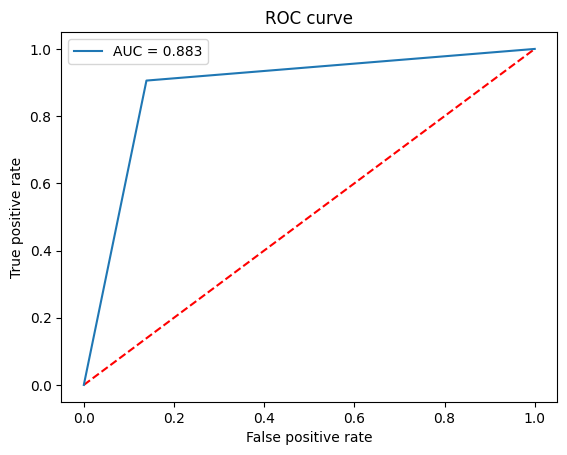

In [74]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

 #### Save Model

 #### Prediction using Xception

In [787]:
# Input image path

pathf="ISIC_0000017.JPG"
img = np.array(load_img(pathf,target_size=(224,224)),dtype=np.float64)
img = np.expand_dims(img,axis=0)
img = preprocess_input(img)
predictions = model.predict(img)

In [788]:
# Prediction using Xception
class_names = ['MEL', 'NV']

pred_canser=class_names[np.argmax(predictions)]
pred_canser

'NV'

In [789]:
predictions

array([[0.38270524, 0.62364346]], dtype=float32)

#### Implement Grad-CAM, Grad-CAM++ .First, implement the function to superimpose original image and heatmap of each cams.

In [37]:
from tensorflow.python.framework.ops import disable_eager_execution

In [38]:
def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

In [39]:
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    original_img=img
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=2, figsize=(9, 4))

    axs[0].imshow(original_img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(superimposed_img)
    axs[1].set_title('superimposed image')
    axs[1].axis('off')

#     axs[2].imshow(superimposed_img)
#     axs[2].set_title('superimposed image')
#     axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

#### Grad-CAM:


In [40]:
## Grad-CAM function

def grad_cam(model, x, layer_name):
    """Grad-CAM function"""
    
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    disable_eager_execution()
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam

#### Grad-CAM++:

In [41]:
## Grad-CAM++ function

def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function"""
    
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads 

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom # 0


    weights = np.maximum(conv_first_grad[0], 0.0)    
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) 
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) 
    
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)
    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0) # Passing through ReLU
    cam /= np.max(cam)       # scale 0 to 1.0  


    return cls, cam

### Compare each visual methods. 

In [42]:
## compare Grad-CAM / Grad-CAM++ 

def _compare(model, layer_name, target_cls):
    """compare Grad-CAM / Grad-CAM++  on target class images"""
    
    indices = np.where(y == target_cls)[0]
    label = class_to_label[target_cls]

    n_cols = 10 # # of sample plot

    fig, axs = plt.subplots(ncols=n_cols, nrows=3, figsize=(25, 9))

    for i in range(n_cols):
        
        img = X[indices[i]]
        # for cam
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0, i].imshow(np.uint8(img))
        axs[0, i].set_title(str(indices[i])+' '+label)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        if i == 0:
            axs[0, i].set_ylabel('Original', rotation=0, ha='right')

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1, i].imshow(img_grad_cam)
        axs[1, i].set_title('pred: ' + class_to_label[cls_pred])
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        if i == 0:
            axs[1, i].set_ylabel('Grad-CAM', rotation=0, ha='right')

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2, i].imshow(img_grad_cam_plus_plus)
        axs[2, i].set_title('pred: ' + class_to_label[cls_pred])
        axs[2, i].set_xticks([])
        axs[2, i].set_yticks([])
        if i == 0:
            axs[2, i].set_ylabel('Grad-CAM++', rotation=0, ha='right')



    plt.show()

In [43]:
## compare Grad-CAM / Grad-CAM++ 

def _compare_an_image(model,img, layer_name):
    """compare Grad-CAM / Grad-CAM++  on target class images"""
    
#     indices = np.where(y == target_cls)[0]
#     label = class_to_label[target_cls]

    n_rows = 1 # # of sample plot

    fig, axs = plt.subplots(ncols=3, nrows=n_rows, figsize=(10, 9))

    for i in range(n_rows):
        
#         original_img = img
#         img=np.uint8(img)
        # for cam        
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0].imshow(np.uint8(img))
        axs[0].set_title('Input image')
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        if i == 0:
            axs[0].set_xlabel('Original')

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1].imshow(img_grad_cam)
        axs[1].set_title('pred: ' + class_to_label[cls_pred])
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        if i == 0:
            axs[1].set_xlabel('Grad-CAM')

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2].imshow(img_grad_cam_plus_plus)
        axs[2].set_title('pred: ' + class_to_label[cls_pred])
        axs[2].set_xticks([])
        axs[2].set_yticks([])
        if i == 0:
            axs[2].set_xlabel('Grad-CAM++')



    plt.show()

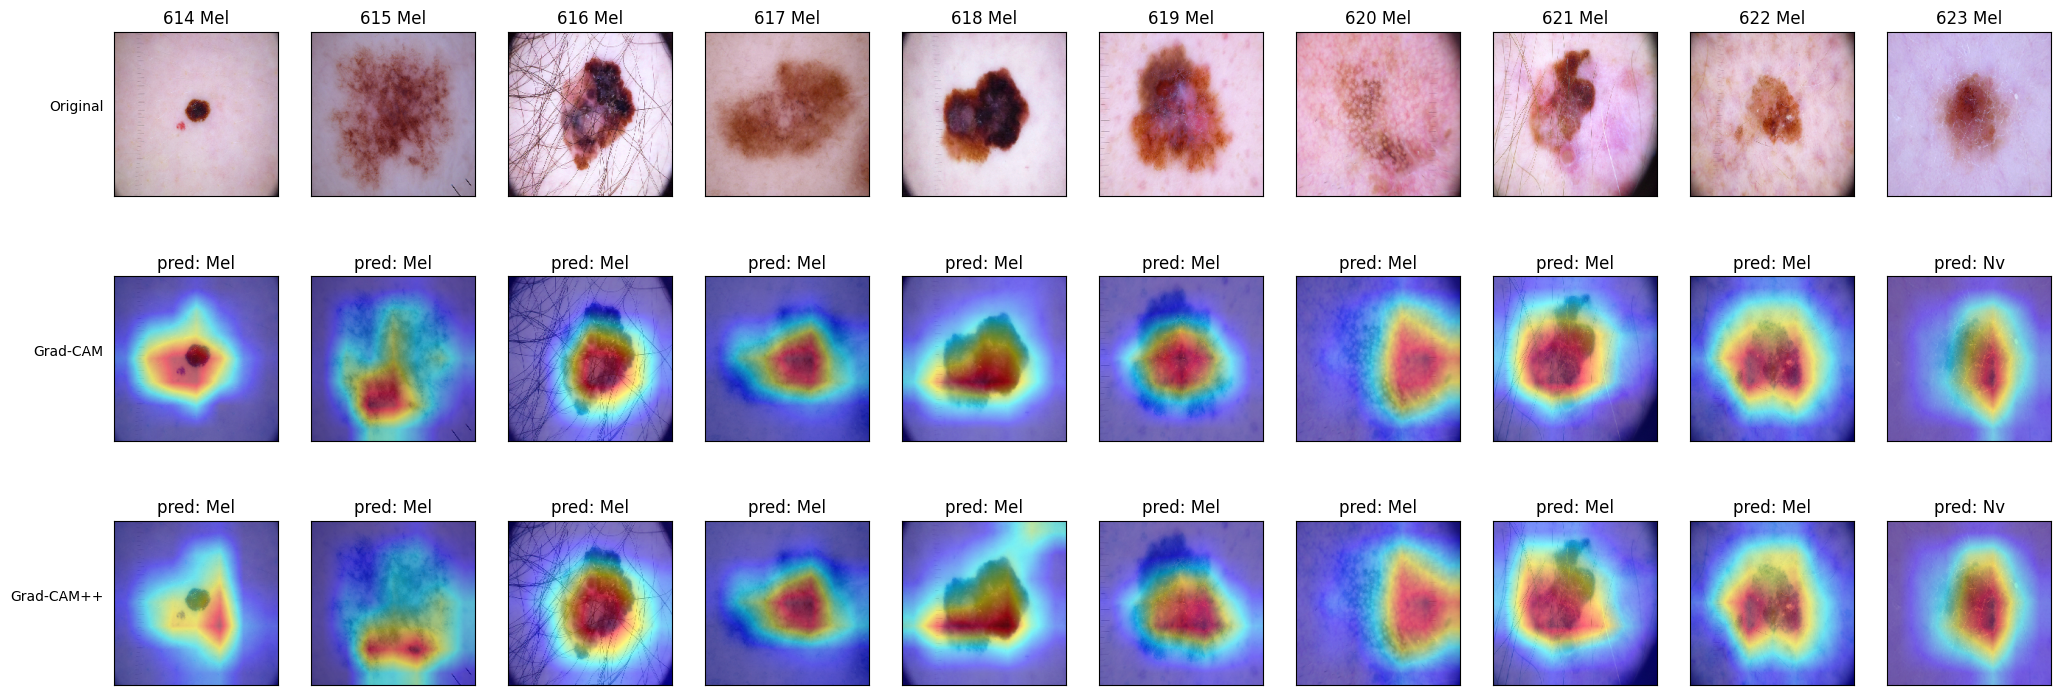

In [46]:
## mel

_compare(model=model, layer_name=model.layers[-5].name, target_cls=0)

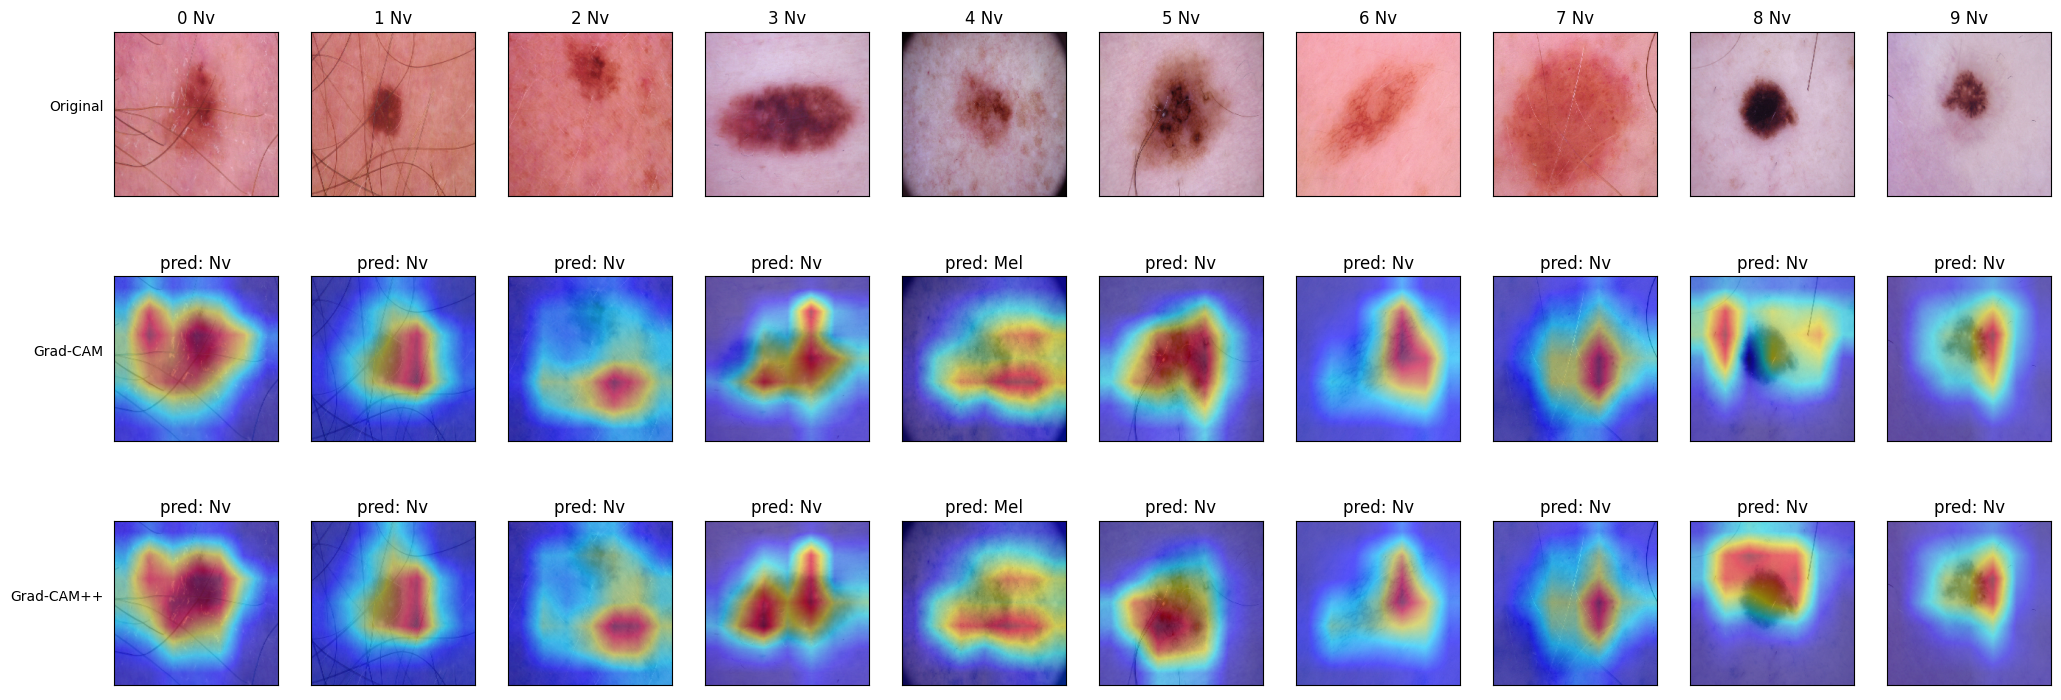

In [241]:
## nv

_compare(model=model, layer_name=model.layers[-5].name, target_cls=1)

In [ ]:
# pathf1='ISIC_0000029.JPG'
# pathf1='ISIC_0000024.JPG'
# pathf1='ISIC_0000034.JPG'
# pathf1='ISIC_0000006.JPG'
# pathf1='ISIC_0000046.JPG'
# pathf1='ISIC_0000049.JPG'
# Grad Cam better
# pathf1='ISIC_0000067.JPG'
# pathf1='ISIC_0000367.JPG'
# pathf1='ISIC_0000403.JPG'
# pathf1='ISIC_0000409.JPG'

#### For an Image

In [66]:
from PIL import Image

pathf1='ISIC_0000521.JPG'
# pathf1='ISIC_0000365.JPG'
# pathf1='ISIC_0000382.JPG'
# pathf1='ISIC_0000416.JPG'


pathf2=pathf1.split('.')[0]+'_attribute_pigment_network.PNG'
pathf3=pathf1.split('.')[0]+'_attribute_negative_network.PNG'
pathf4=pathf1.split('.')[0]+'_attribute_globules.PNG'
pathf5=pathf1.split('.')[0]+'_attribute_streaks.PNG'
pathf6=pathf1.split('.')[0]+'_attribute_milia_like_cyst.PNG'

img = np.array(load_img(pathf1,target_size=(224,224,3)),dtype=np.float64)
img2 = np.array(load_img(pathf2,target_size=(224,224)),dtype=np.float64)
img3 = np.array(load_img(pathf3,target_size=(224,224)),dtype=np.float64)
img4 = np.array(load_img(pathf4,target_size=(224,224)),dtype=np.float64)
img5 = np.array(load_img(pathf5,target_size=(224,224)),dtype=np.float64)
img6 = np.array(load_img(pathf6,target_size=(224,224)),dtype=np.float64)
# # img = np.expand_dims(img,axis=0)
# img = preprocess_input(img)
# img=img/255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


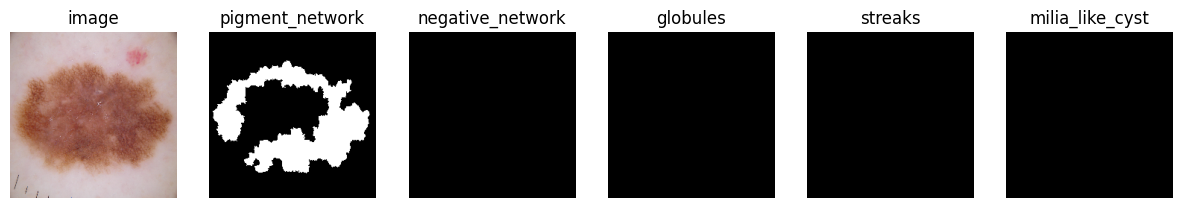

In [67]:
W_grid=6
L_grid=1
fig,axes = plt.subplots(L_grid,W_grid,figsize=(15,15))
axes=axes.ravel()

# index=np.random.randint(0,n_training) #Pick a random number 
axes[0].imshow(img/255)
axes[0].set_title("image") #Prints labels on top of the picture
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("pigment_network") #Prints labels on top of the picture
axes[1].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[2].imshow(img3)
axes[2].set_title("negative_network") #Prints labels on top of the picture
axes[2].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[3].imshow(img4)
axes[3].set_title("globules") #Prints labels on top of the picture
axes[3].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[4].imshow(img5)
axes[4].set_title("streaks") #Prints labels on top of the picture
axes[4].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[5].imshow(img6)
axes[5].set_title("milia_like_cyst") #Prints labels on top of the picture
axes[5].axis('off')
plt.subplots_adjust(hspace=0.5)

In [59]:
# grad_cam and  grad_cam_plus_plus for the input image

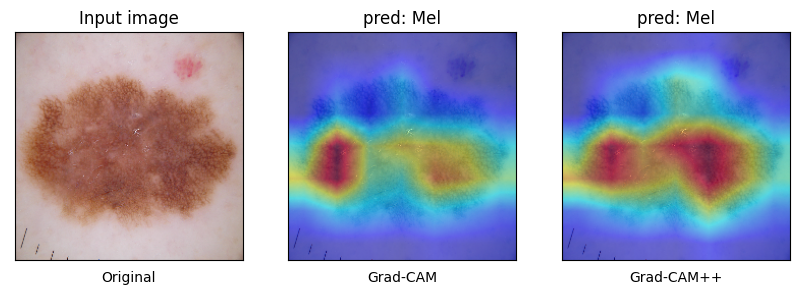

In [644]:
# ISIC_0000521
_compare_an_image(model,img,model.layers[-5].name)

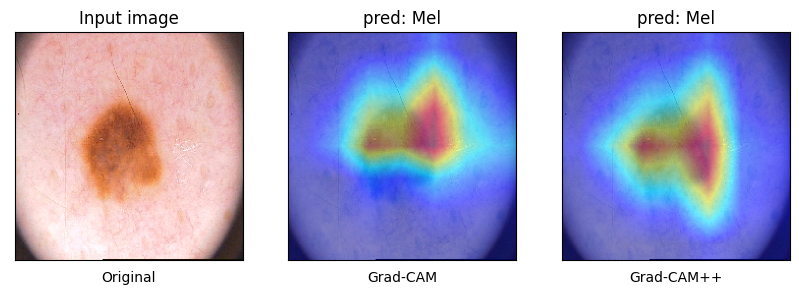

In [62]:
# ISIC_0000365
_compare_an_image(model,img,model.layers[-5].name)

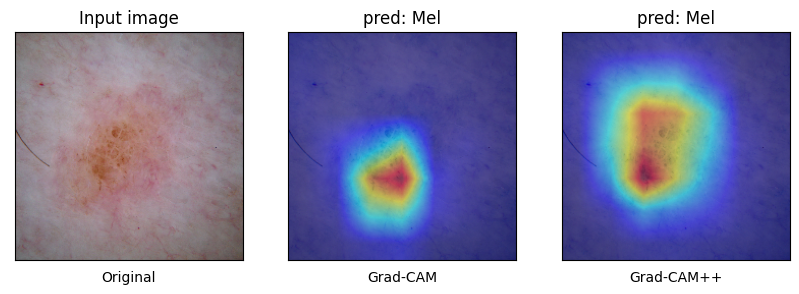

In [770]:
# ISIC_0000382
_compare_an_image(model,img,model.layers[-5].name)

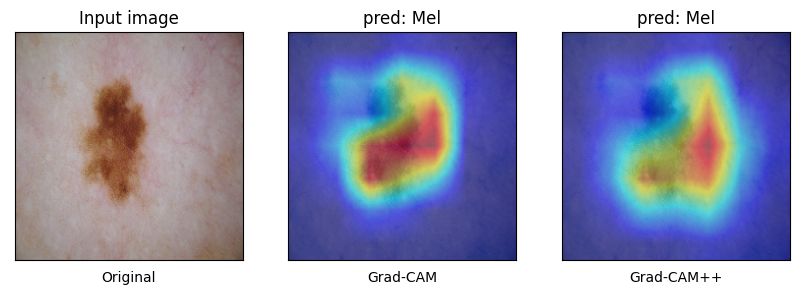

In [649]:
# ISIC_0000416
_compare_an_image(model,img,model.layers[-5].name)

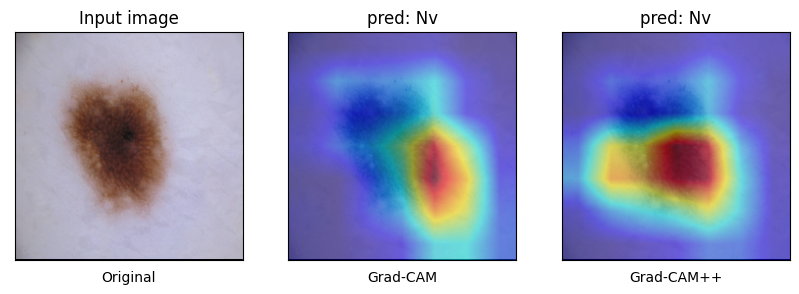

In [754]:
# ISIC_0000047
_compare_an_image(model,img,model.layers[-5].name)